# ============================================================
# NN Stance Classifier (XLM-R base) + Reglas + Abstención
# Entrena con ~9k y clasifica ~100k con logging y progreso.
# ============================================================

In [ ]:
#%pip install --upgrade openpyxl
%pip install tf_keras
%pip install tensorflow

##### 1) ENTRENA (TF/Keras) con 9.000 y CLASIFICAR ~100k
#####    Reglas + DistilBERT Multilingüe (TensorFlow) + Abstención

In [1]:

import re, math, json, logging
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Optional

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support, accuracy_score
from scipy.special import softmax

from transformers import (
    AutoTokenizer, TFAutoModelForSequenceClassification
)

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
os.environ["USE_TF"] = "1"
os.environ["TRANSFORMERS_NO_TORCH"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Reduce TensorFlow logging (1: errors, 2: warnings, 3: info)


In [2]:
# ----------------------------
# Paths y configuración
# ----------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

MODEL_NAME = "distilbert-base-multilingual-cased"  # TF-friendly, multilingüe
OUTPUT_DIR = "../models/tf_distilmbert_stance_v1"
LOG_DIR = "../logs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [ ]:
# Archivos
PATH_9K  = "../data/processed/6_9000_comments_hibrid_class.xlsx"   # tiene label_final, clasificacion_origen, ml_proba_max, ml_margen (opc.)
PATH_FULL = "../data/processed/3_comments_youtube_with_insults.csv"          # 113.585 con 'insulto' y 'n_insultos'
OUT_FULL = "../data/processed/7_final_label.csv"                      # salida final con predicciones

LABELS = ["ruso", "ucraniano", "neutro"]
LABEL2ID = {l:i for i,l in enumerate(LABELS)}
ID2LABEL = {i:l for l,i in LABEL2ID.items()}

In [5]:
# ----------------------------
# Logging a archivo + consola
# ----------------------------
logging.basicConfig(
    filename=os.path.join(LOG_DIR, "tf_training_inference.log"),
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)
console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s] %(message)s"))
logging.getLogger().addHandler(console)
logging.info("=== Inicio TF DistilBERT stance ===")

2025-10-14 01:18:56,903 [INFO] === Inicio TF DistilBERT stance ===


In [4]:
# ----------------------------
# Utilidades de texto y reglas
# ----------------------------
def clean_text(s: str) -> str:
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"@[A-Za-z0-9_]+", " ", s)
    s = re.sub(r"[^A-Za-zÀ-ÿ0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

def contains_any(s: str, bag: List[str]) -> bool:
    s = s.lower()
    return any(k in s for k in bag)


PRAISE = [
    "gran canal","buen canal","buen vídeo","gran vídeo","gracias por informar","excelente análisis", 
    "buen canal","buen análisis","buen analisis","me gusta el canal","me encanta", "canal objetivo", 
    "muy claro","te felicito","gracias por el análisis", "buen resumen" 
]
RUS_POWER = [
    "sarmat","misil","misiles","hipersónico","hipersonico","alcance nuclear",
    "no se metan con rusia","no se metan con los rusos","poder ruso","armamento ruso","potencia rusa",
    "khinzal","kinzhal","avangard","poseidon","tsirkon","zircón","isdm","kalibr", "borrar kiev"
]
PEACE = [
    "paz","alto el fuego","alto al fuego","basta de guerra","tragedia para ambos",
    "muertes","sufrimiento","fin de la guerra","paren la guerra","que pare la guerra",
    "humanitario","ayuda humanitaria","no más guerra", "no mas guerra","acuerdo de paz"
]
ANTI_OCC = [
    "otan","cnn","occidente","eeuu","estados unidos","propaganda occidental","mentira occidental",
    "ue propaganda","nato", "occidente decadente","imperio yanqui","globalistas","agenda 2030"
]
ANTI_RUS = [
    "putin asesino","dictador","rusia invasora","invasión rusa","invasion rusa",
    "rusos mentirosos","propaganda rusa","kremlin miente","criminal de guerra",
    "rusia criminal","imperio ruso","genocidas rusos","terrorismo ruso","criminales rusos", 
    "bot ruso"
]

In [6]:
def rule_classifier(row):
    text  = str(row["comment"]).lower()
    canal = str(row["condiciones_cuenta"]).strip().lower()  # 'pro-ucraniano'/'pro-ruso'/'neutral'
    insult = bool(row.get("insulto", False))
    fuera  = str(row.get("fuera_de_contexto","")).lower() in {"sí","si","true"}

    if fuera:
        return None, "regla-fuera-contexto"

    if insult and canal in {"pro-ucraniano","pro-ruso"}:
        return ("ruso" if canal=="pro-ucraniano" else "ucraniano"), "regla-insulto-inversion"

    if contains_any(text, PRAISE) and canal in {"pro-ucraniano","pro-ruso"}:
        return ("ucraniano" if canal=="pro-ucraniano" else "ruso"), "regla-elogio-canal"

    if contains_any(text, RUS_POWER):
        if any(w in text for w in ["potente","poderoso","impresionante","temible","arras","reventar","alcance","amenaza","hongo","nuclear","golpear"]):
            return "ruso", "regla-poder-ruso"

    if contains_any(text, PEACE) and not insult:
        if not contains_any(text, ANTI_OCC) and not contains_any(text, ANTI_RUS):
            return "neutro", "regla-paz-humanitaria"

    if canal == "pro-ucraniano" and contains_any(text, ANTI_OCC):
        return "ruso", "regla-anti-occidente-en-canal-pro-ucr"

    if contains_any(text, ANTI_RUS):
        return "ucraniano", "regla-anti-rusia"

    if "putin" in text and any(w in text for w in ["asesino","dictador","criminal","títere","titere"]):
        return "ucraniano", "regla-putin-neg"

    if "zelensky" in text and any(w in text for w in ["títere","titere","payaso","corrupto","actor"]):
        return "ruso", "regla-zelensky-neg"

    if canal == "neutral" and contains_any(text, PRAISE):
        return "neutro", "regla-elogio-canal-neutral"

    return None, None

In [7]:
# ----------------------------
# Cargamos los 9k y preparar train
# ----------------------------
df9k = pd.read_excel(PATH_9K)
df9k["comment"] = df9k["comment"].astype(str)
df9k["condiciones_cuenta"] = df9k["condiciones_cuenta"].astype(str).str.strip().str.lower()
df9k["comment_clean"] = df9k["comment"].apply(clean_text)
df9k["text_with_ctx"] = (("[canal:"+df9k["condiciones_cuenta"]+"] ") + df9k["comment_clean"]).str.strip()

valid_labels = set(LABELS)
df9k["label_final"] = df9k["label_final"].astype(str).str.strip().str.lower()
df9k["clasificacion_origen"] = df9k["clasificacion_origen"].astype(str).str.strip().str.lower()


In [8]:
# criterio de calidad para entrenar:
mask_h = (df9k["clasificacion_origen"] == "humano") & (df9k["label_final"].isin(valid_labels))
mask_r = (df9k["clasificacion_origen"] == "regla") & (df9k["label_final"].isin(valid_labels))
if "ml_proba_max" in df9k.columns and "ml_margen" in df9k.columns:
    mask_m = (df9k["clasificacion_origen"] == "automatica-ml") & \
             (df9k["label_final"].isin(valid_labels)) & \
             (df9k["ml_proba_max"] >= 0.60) & (df9k["ml_margen"] >= 0.20)
else:
    mask_m = (df9k["clasificacion_origen"] == "automatica-ml") & (df9k["label_final"].isin(valid_labels))

df_train = df9k[mask_h | mask_r | mask_m].copy()
print("Train por origen:\n", df_train["clasificacion_origen"].value_counts())

Train por origen:
 clasificacion_origen
automatica-ml    3304
humano           1877
Name: count, dtype: int64


In [9]:
# sample weights por origen
WEIGHTS_ORIGEN = {"humano":1.0, "regla":0.85, "automatica-ml":0.7}
df_train["sample_weight"] = df_train["clasificacion_origen"].map(WEIGHTS_ORIGEN).fillna(0.7)

X_all = df_train["text_with_ctx"].tolist()
y_all = df_train["label_final"].map(LABEL2ID).values
w_all = df_train["sample_weight"].values

Xtr, Xva, ytr, yva, wtr, wva = train_test_split(
    X_all, y_all, w_all, test_size=0.2, random_state=RANDOM_SEED, stratify=y_all
)

In [10]:
# ----------------------------
# Tokenizer y TF Datasets
# ----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
MAX_LEN = 200
BATCH_TRAIN = 16
BATCH_VAL = 32

def encode_batch(texts):
    enc = tokenizer(texts, truncation=True, padding="max_length", max_length=MAX_LEN)
    return {k: np.array(v) for k,v in enc.items()}

enc_tr = encode_batch(Xtr)
enc_va = encode_batch(Xva)

train_ds = tf.data.Dataset.from_tensor_slices((enc_tr, ytr, wtr)).shuffle(2048, seed=RANDOM_SEED).batch(BATCH_TRAIN).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((enc_va, yva, wva)).batch(BATCH_VAL).prefetch(tf.data.AUTOTUNE)


c:\Users\User\Desktop\Facu\Master_Espana\Master_UEMC\TFM\codigo\analisis_guerra_ucrania_youtube\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# Tokenizer (carga desde checkpoint si existe, si no desde el modelo base)
if "tokenizer" not in globals():
    if os.path.isdir(OUTPUT_DIR):
        try:
            tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR, use_fast=True)
        except Exception:
            tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
    else:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# Modelo (primero intenta checkpoint ../models/.../best, si no usa el base)
best_ckpt = os.path.join(OUTPUT_DIR, "best")
try:
    if os.path.isdir(best_ckpt):
        model = TFAutoModelForSequenceClassification.from_pretrained(
            best_ckpt,
            num_labels=len(LABELS),
            id2label=ID2LABEL,
            label2id=LABEL2ID,
        )
        print("Modelo cargado desde checkpoint:", best_ckpt)
    else:
        raise FileNotFoundError
except Exception as e:
    model = TFAutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(LABELS),
        id2label=ID2LABEL,
        label2id=LABEL2ID,
    )
    print("Modelo inicializado desde", MODEL_NAME)

2025-10-14 01:20:24,825 [WARNING] From c:\Users\User\Desktop\Facu\Master_Espana\Master_UEMC\TFM\codigo\analisis_guerra_ucrania_youtube\.venv\Lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSe

Modelo inicializado desde distilbert-base-multilingual-cased


In [42]:
# OPTIMIZER / LOSS / METRICS con Keras 3
lr = 3e-5
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss      = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics   = [keras.metrics.SparseCategoricalAccuracy(name="acc")]

# Dataset ya emite (enc, y, sw). Asegura dtypes (opcional pero recomendable)
train_ds = train_ds.map(lambda enc, y, sw: (enc, tf.cast(y, tf.int32), tf.cast(sw, tf.float32)))
val_ds   = val_ds.map(lambda enc, y, sw: (enc, tf.cast(y, tf.int32), tf.cast(sw, tf.float32)))

# Compilar el modelo HF (TFDistilBertForSequenceClassification) con Keras 3
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



In [20]:
# CALLBACKS con Keras 3 (NO uses tf.keras.callbacks.*)
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(
        "../models/tf_distilmbert_stance_v1/best",
        save_weights_only=False,
        save_best_only=True,
        monitor="val_loss"
    ),
    keras.callbacks.CSVLogger("../logs/tf_training_log.csv"),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/3



2025-10-10 19:44:10,902 [WARNING] From c:\Users\User\Desktop\Facu\Master_Espana\Master_UEMC\TFM\codigo\analisis_guerra_ucrania_youtube\.venv\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.



259/259 [==============================] - ETA: 0s - loss: 0.5875 - acc: 0.7413WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2025-10-10 20:08:18,035 [WARNING] `evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2025-10-10 20:09:59,601 [WARNING] From c:\Users\User\Desktop\Facu\Master_Espana\Master_UEMC\TFM\codigo\analisis_guerra_ucrania_youtube\.venv\Lib\site-packages\keras\src\saving\legacy\saved_model\save_impl.py:66: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.



2025-10-10 20:09:59,603 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E732290>, because it is not built.


2025-10-10 20:09:59,618 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E761110>, because it is not built.


2025-10-10 20:09:59,645 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E635310>, because it is not built.


2025-10-10 20:09:59,662 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E804190>, because it is not built.


2025-10-10 20:09:59,680 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E4FBB90>, because it is not built.


2025-10-10 20:09:59,701 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546DAD4210>, because it is not built.


INFO:tensorflow:Assets written to: ../models/tf_distilmbert_stance_v1\best\assets


2025-10-10 20:10:23,680 [INFO] Assets written to: ../models/tf_distilmbert_stance_v1\best\assets


259/259 [==============================] - 1580s 6s/step - loss: 0.5875 - acc: 0.7413 - val_loss: 0.4919 - val_acc: 0.7898
Epoch 2/3
259/259 [==============================] - ETA: 0s - loss: 0.3778 - acc: 0.8381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2025-10-10 20:33:11,684 [WARNING] `evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2025-10-10 20:34:40,463 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E732290>, because it is not built.


2025-10-10 20:34:40,479 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E761110>, because it is not built.


2025-10-10 20:34:40,493 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E635310>, because it is not built.


2025-10-10 20:34:40,514 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E804190>, because it is not built.


2025-10-10 20:34:40,532 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E4FBB90>, because it is not built.


2025-10-10 20:34:40,547 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546DAD4210>, because it is not built.


INFO:tensorflow:Assets written to: ../models/tf_distilmbert_stance_v1\best\assets


2025-10-10 20:35:00,505 [INFO] Assets written to: ../models/tf_distilmbert_stance_v1\best\assets


259/259 [==============================] - 1476s 6s/step - loss: 0.3778 - acc: 0.8381 - val_loss: 0.4596 - val_acc: 0.7994
Epoch 3/3
259/259 [==============================] - ETA: 0s - loss: 0.2196 - acc: 0.9199WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2025-10-10 20:58:15,494 [WARNING] `evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2025-10-10 20:59:46,688 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E732290>, because it is not built.


2025-10-10 20:59:46,688 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E761110>, because it is not built.


2025-10-10 20:59:46,698 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E635310>, because it is not built.


2025-10-10 20:59:46,723 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E804190>, because it is not built.


2025-10-10 20:59:46,735 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546E4FBB90>, because it is not built.


2025-10-10 20:59:46,754 [WARNING] Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x000001546DAD4210>, because it is not built.


INFO:tensorflow:Assets written to: ../models/tf_distilmbert_stance_v1\best\assets


2025-10-10 21:00:07,524 [INFO] Assets written to: ../models/tf_distilmbert_stance_v1\best\assets


259/259 [==============================] - 1507s 6s/step - loss: 0.2196 - acc: 0.9199 - val_loss: 0.4519 - val_acc: 0.8274


In [ ]:
# ============================
# POST-ENTRENAMIENTO COMPLETO
# (Eval + F1 + Gráficos + Guardado + Inferencia con abstención)
# ============================



In [14]:
# ----------------------------
# 0) Utilidades / defaults
# ----------------------------
# Define umbrales por defecto para abstención
UMBRAL_PROBA = 0.55
UMBRAL_MARGEN = 0.15

# Asegura nombres de columnas en CSVLogger
LOG_PATH = "../logs/tf_training_log.csv"
OUTPUT_DIR = "../models/tf_distilmbert_stance_export"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [43]:
# ----------------------------
# 1) Evaluación en validación
# ----------------------------
# Crea un dataset de validación SIN sample_weight para predecir sin warnings
val_ds_no_sw = tf.data.Dataset.from_tensor_slices((enc_va, yva)) \
    .batch(BATCH_VAL).prefetch(tf.data.AUTOTUNE)

# Predicción: obtiene logits y predicciones top-1
out = model.predict(val_ds_no_sw.map(lambda enc, y: ({k: enc[k] for k in ["input_ids","attention_mask"]}, y)),
                    verbose=0)
logits = out.logits if hasattr(out, "logits") else out  # por compatibilidad
yhat = logits.argmax(axis=1)

print("=== Eval TF DistilBERT (validación) ===")

=== Eval TF DistilBERT (validación) ===


In [44]:
# Reporte con yva/yhat. Si quieres ponderar por pesos, pasa sample_weight=wva
try:
    print(classification_report(yva, yhat, target_names=LABELS, digits=3, sample_weight=wva))
    f1_macro = f1_score(yva, yhat, average="macro", sample_weight=wva)
    f1_weighted = f1_score(yva, yhat, average="weighted", sample_weight=wva)
except NameError:
    print(classification_report(yva, yhat, target_names=LABELS, digits=3))
    f1_macro = f1_score(yva, yhat, average="macro")
    f1_weighted = f1_score(yva, yhat, average="weighted")

print(f"F1 macro: {f1_macro:.3f} | F1 weighted: {f1_weighted:.3f}")


              precision    recall  f1-score   support

        ruso      0.849     0.925     0.886 585.1999999999996
   ucraniano      0.744     0.542     0.627 135.00000000000014
      neutro      0.645     0.556     0.597 112.50000000000013

    accuracy                          0.813 832.6999999999998
   macro avg      0.746     0.675     0.703 832.6999999999998
weighted avg      0.805     0.813     0.805 832.6999999999998

F1 macro: 0.703 | F1 weighted: 0.805


In [45]:
# Matriz de confusión
cm = confusion_matrix(yva, yhat, labels=range(len(LABELS)))
cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in LABELS], columns=[f"pred_{l}" for l in LABELS])
print("\nMatriz de confusión:\n", cm_df)

# Métricas por clase (precision/recall/F1/support)
try:
    pr, rc, f1c, sup = precision_recall_fscore_support(yva, yhat, labels=range(len(LABELS)),
                                                       sample_weight=wva, zero_division=0)
except NameError:
    pr, rc, f1c, sup = precision_recall_fscore_support(yva, yhat, labels=range(len(LABELS)),
                                                       zero_division=0)
per_class_df = pd.DataFrame({"label": LABELS, "precision": pr, "recall": rc, "f1": f1c, "support": sup})
print("\nMétricas por clase:\n", per_class_df)


Matriz de confusión:
                 pred_ruso  pred_ucraniano  pred_neutro
true_ruso             691              19           33
true_ucraniano         60              90            9
true_neutro            50               8           77

Métricas por clase:
        label  precision    recall        f1  support
0       ruso   0.849498  0.924983  0.885635    585.2
1  ucraniano   0.743902  0.542222  0.627249    135.0
2     neutro   0.644696  0.556444  0.597328    112.5


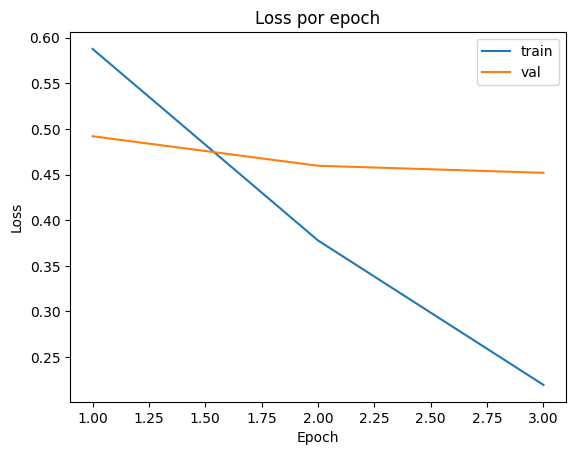

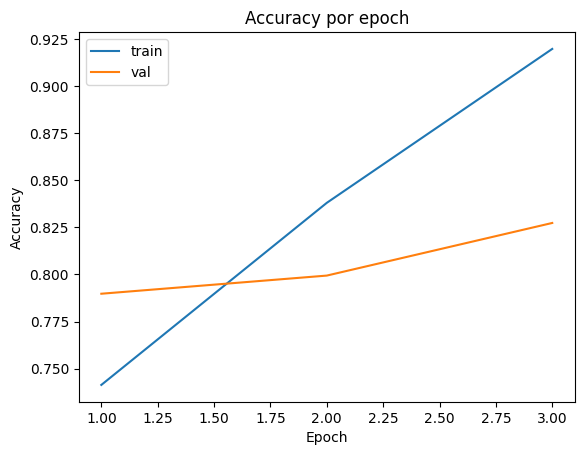

In [27]:
# ----------------------------
# 2) Gráficos (loss/acc y F1 por clase)
# ----------------------------
if os.path.exists(LOG_PATH):
    df_log = pd.read_csv(LOG_PATH)
    ep = range(1, len(df_log)+1)

    # Loss
    plt.figure()
    plt.plot(ep, df_log["loss"], label="train")
    if "val_loss" in df_log.columns: plt.plot(ep, df_log["val_loss"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss por epoch"); plt.legend(); plt.show()

    # Accuracy (según cómo lo compilaste, puede llamarse acc/accuracy)
    acc_col = "acc" if "acc" in df_log.columns else ("accuracy" if "accuracy" in df_log.columns else None)
    val_acc_col = "val_acc" if "val_acc" in df_log.columns else ("val_accuracy" if "val_accuracy" in df_log.columns else None)
    if acc_col:
        plt.figure()
        plt.plot(ep, df_log[acc_col], label="train")
        if val_acc_col: plt.plot(ep, df_log[val_acc_col], label="val")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy por epoch"); plt.legend(); plt.show()
else:
    print(f"Aviso: no se encontró el log en {LOG_PATH}. ¿CSVLogger se configuró correctamente?")


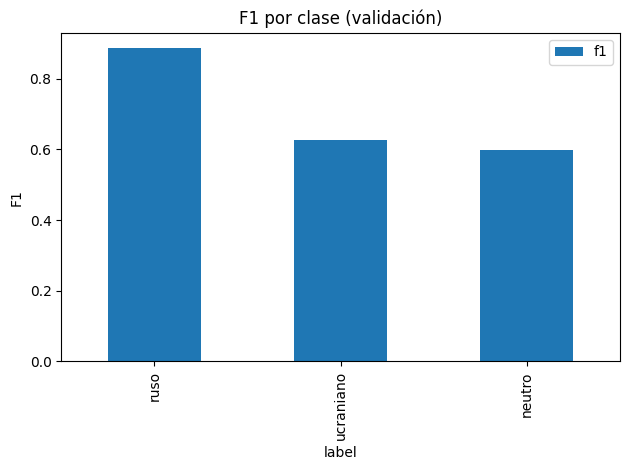

In [28]:
# F1 por clase (barras)
ax = per_class_df.plot(x="label", y="f1", kind="bar")
plt.title("F1 por clase (validación)")
plt.ylabel("F1")
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# 3) Guardado del modelo/tokenizer
# ----------------------------
# Si entrenaste con TF *AutoModelForSequenceClassification* (HF TF), esto guarda el modelo en formato HF:
try:
    model.save_pretrained(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    print("Modelo y tokenizer guardados en", OUTPUT_DIR)
except Exception as e:
    print("No se pudo guardar con save_pretrained. Detalle:", repr(e))
    # Fallback SavedModel
    tf.saved_model.save(model, os.path.join(OUTPUT_DIR, "savedmodel"))
    print("Guardado en formato SavedModel:", os.path.join(OUTPUT_DIR, "savedmodel"))

✅ Modelo y tokenizer guardados en ../models/tf_distilmbert_stance_export


In [ ]:
# ----------------------------
# 4) Inferencia en ~100k con abstención con el modelo ya creado
# ----------------------------
# Requiere: PATH_FULL, clean_text, rule_classifier, LABELS, tokenizer, MAX_LEN

In [28]:
#Import del modelo ya creado
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(r"../models/tf_distilmbert_stance_export", use_fast=True); model = TFAutoModelForSequenceClassification.from_pretrained(r"../models/tf_distilmbert_stance_export")


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ../models/tf_distilmbert_stance_export.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [31]:
# === Setup salida CSV + validaciones ===
CHUNK        = 30_000            # filas por chunk (RAM estable)
BATCH_INFER  = 512               # tamaño de lote para el modelo
MILESTONE    = 30_000            # aviso cada 30k procesadas

# Validaciones (evita NameError a mitad de camino)
required = ["PATH_FULL","clean_text","rule_classifier","LABELS","MAX_LEN","UMBRAL_PROBA","UMBRAL_MARGEN"]
missing = [v for v in required if v not in globals()]
assert not missing, f"Faltan variables/funciones: {missing}"
assert "tokenizer" in globals(), "Falta 'tokenizer' (cargalo desde ../models/tf_distilmbert_stance_export)"
assert "model" in globals(), "Falta 'model' (cargalo desde ../models/tf_distilmbert_stance_export)"

# Si existe un CSV previo, lo borro para escribir encabezado una sola vez
if os.path.exists(OUT_FULL):
    os.remove(OUT_FULL)

print("Salida CSV:", OUT_FULL)


Salida CSV: ../data/processed/7_predicciones_full_small_v2_testing.csv


In [ ]:

# #Version 1, ahorrando ram
# def batched(iterable, n):
#     for i in range(0, len(iterable), n):
#         yield iterable[i:i+n]

# def infer_chunk_to_df(df_chunk: pd.DataFrame) -> pd.DataFrame:
#     # Normalización
#     df_chunk["comment"] = df_chunk["comment"].astype(str)
#     df_chunk["condiciones_cuenta"] = df_chunk["condiciones_cuenta"].astype(str).str.strip().str.lower()
#     df_chunk["comment_clean"] = df_chunk["comment"].apply(clean_text)
#     df_chunk["text_with_ctx"] = (("[canal:"+df_chunk["condiciones_cuenta"]+"] ") + df_chunk["comment_clean"]).str.strip()

#     # Reglas primero
#     df_chunk["label_rule"] = None
#     df_chunk["regla_aplicada"] = None
#     for i in range(len(df_chunk)):
#         lab, rname = rule_classifier(df_chunk.iloc[i])
#         df_chunk.iat[i, df_chunk.columns.get_loc("label_rule")] = lab
#         df_chunk.iat[i, df_chunk.columns.get_loc("regla_aplicada")] = rname

#     is_rule = df_chunk["label_rule"].isin(LABELS)
#     to_pred_mask = ~is_rule

#     # Inferencia NN en lotes (solo filas sin regla)
#     idxs  = df_chunk.loc[to_pred_mask].index.tolist()
#     texts = df_chunk.loc[to_pred_mask, "text_with_ctx"].tolist()

#     top1_lab_all, pmax_all, marg_all, entr_all = [], [], [], []
#     for chunk_txt in batched(texts, BATCH_INFER):
#         enc = tokenizer(chunk_txt, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="tf")
#         out = model(enc, training=False)
#         logits_np = out.logits.numpy() if hasattr(out, "logits") else out.numpy()
#         probas = tf.nn.softmax(logits_np, axis=1).numpy()

#         top1_idx = probas.argmax(axis=1)
#         top1_lab = np.array(LABELS)[top1_idx]
#         top1_p   = probas[np.arange(probas.shape[0]), top1_idx]
#         sorted_p = -np.sort(-probas, axis=1)
#         marg     = sorted_p[:, 0] - sorted_p[:, 1]
#         entropy  = -(probas * (np.log(probas + 1e-12))).sum(axis=1)

#         top1_lab_all.append(top1_lab)
#         pmax_all.append(top1_p)
#         marg_all.append(marg)
#         entr_all.append(entropy)

#     if len(top1_lab_all):
#         df_chunk.loc[idxs, "label_ml"]     = np.concatenate(top1_lab_all)
#         df_chunk.loc[idxs, "ml_proba_max"] = np.concatenate(pmax_all)
#         df_chunk.loc[idxs, "ml_margen"]    = np.concatenate(marg_all)
#         df_chunk.loc[idxs, "ml_entropia"]  = np.concatenate(entr_all)
#     else:
#         df_chunk["label_ml"]     = np.nan
#         df_chunk["ml_proba_max"] = np.nan
#         df_chunk["ml_margen"]    = np.nan
#         df_chunk["ml_entropia"]  = np.nan

#     # Decisión final con abstención
#     dec_lab, dec_src = [], []
#     for lab, pmax, mg in zip(
#         df_chunk["label_ml"].fillna(""),
#         df_chunk["ml_proba_max"].fillna(0.0),
#         df_chunk["ml_margen"].fillna(0.0),
#     ):
#         if (pmax >= UMBRAL_PROBA) and (mg >= UMBRAL_MARGEN):
#             dec_lab.append(lab); dec_src.append("automatica-nn-tf")
#         else:
#             dec_lab.append("");  dec_src.append("sin-clasificar")
#     df_chunk["label_final"] = dec_lab
#     df_chunk["clasificacion_origen"] = dec_src

#     # Reglas tienen prioridad
#     df_chunk.loc[is_rule, "label_final"] = df_chunk.loc[is_rule, "label_rule"]
#     df_chunk.loc[is_rule, "clasificacion_origen"] = "regla"

#     return df_chunk

# # --- Bucle por chunks a CSV con logs cada 30k ---
# first = True
# processed = 0
# next_milestone = MILESTONE

# for df_part in pd.read_csv(PATH_FULL, chunksize=CHUNK):
#     df_out = infer_chunk_to_df(df_part)

#     df_out.to_csv(
#         OUT_FULL,
#         mode="w" if first else "a",
#         header=first,
#         index=False,
#         encoding="utf-8-sig",
#         lineterminator="\n"
#     )
#     first = False

#     processed += len(df_part)
#     if processed >= next_milestone:
#         print(f"Progreso: {processed:,} filas procesadas y guardadas en CSV")
#         next_milestone += MILESTONE

# print(f"Inferencia terminada → {OUT_FULL}")

In [33]:
#Deprectado: inferencia en un solo paso (carga todo en RAM)
try:
    print("\n== Inferencia en lote con reglas + NN + abstención ==")
    df_full = pd.read_csv(PATH_FULL)
    df_full["comment"] = df_full["comment"].astype(str)
    df_full["condiciones_cuenta"] = df_full["condiciones_cuenta"].astype(str).str.strip().str.lower()

    # Limpieza + contexto (ajusta clean_text si lo deseas más agresivo)
    df_full["comment_clean"] = df_full["comment"].apply(clean_text)
    df_full["text_with_ctx"] = (("[canal:"+df_full["condiciones_cuenta"]+"] ") + df_full["comment_clean"]).str.strip()

    # 4.1 Reglas primero
    df_full["label_rule"] = None
    df_full["regla_aplicada"] = None
    for i in range(len(df_full)):
        lab, rname = rule_classifier(df_full.iloc[i])
        df_full.iat[i, df_full.columns.get_loc("label_rule")] = lab
        df_full.iat[i, df_full.columns.get_loc("regla_aplicada")] = rname

    is_rule = df_full["label_rule"].isin(LABELS)
    to_pred_mask = ~is_rule

    # 4.2 Inferencia por lotes con TF
    BATCH_INFER = 512
    texts = df_full.loc[to_pred_mask, "text_with_ctx"].tolist()
    idxs  = df_full.loc[to_pred_mask].index.tolist()

    top1_lab_all, pmax_all, marg_all, entr_all = [], [], [], []

    def batched(iterable, n):
        for i in range(0, len(iterable), n):
            yield iterable[i:i+n]

    for chunk in batched(texts, BATCH_INFER):
        enc = tokenizer(chunk, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="tf")
        out = model(enc, training=False)
        logits_np = out.logits.numpy() if hasattr(out, "logits") else out.numpy()
        probas = tf.nn.softmax(logits_np, axis=1).numpy()

        top1_idx = probas.argmax(axis=1)
        top1_lab = np.array(LABELS)[top1_idx]
        top1_p = probas[np.arange(probas.shape[0]), top1_idx]

        sorted_p = -np.sort(-probas, axis=1)
        marg = sorted_p[:,0] - sorted_p[:,1]
        entropy = -(probas * (np.log(probas + 1e-12))).sum(axis=1)  # opcional para análisis

        top1_lab_all.append(top1_lab)
        pmax_all.append(top1_p)
        marg_all.append(marg)
        entr_all.append(entropy)

    if len(top1_lab_all) > 0:
        top1_lab_all = np.concatenate(top1_lab_all)
        pmax_all     = np.concatenate(pmax_all)
        marg_all     = np.concatenate(marg_all)
        entr_all     = np.concatenate(entr_all)
    else:
        top1_lab_all = np.array([]); pmax_all = np.array([]); marg_all = np.array([]); entr_all = np.array([])

    df_full.loc[idxs, "label_ml"] = top1_lab_all
    df_full.loc[idxs, "ml_proba_max"] = pmax_all
    df_full.loc[idxs, "ml_margen"] = marg_all
    df_full.loc[idxs, "ml_entropia"] = entr_all

    # 4.3 Decisión final con abstención (NN)
    dec_lab = []
    dec_src = []
    for lab, pmax, mg in zip(top1_lab_all, pmax_all, marg_all):
        if (pmax >= UMBRAL_PROBA) and (mg >= UMBRAL_MARGEN):
            dec_lab.append(lab); dec_src.append("automatica-nn-tf")
        else:
            dec_lab.append("");  dec_src.append("sin-clasificar")
    df_full.loc[idxs, "label_final"] = dec_lab
    df_full.loc[idxs, "clasificacion_origen"] = dec_src

    # 4.4 Reglas tienen prioridad
    df_full.loc[is_rule, "label_final"] = df_full.loc[is_rule, "label_rule"]
    df_full.loc[is_rule, "clasificacion_origen"] = "regla"

    print("\n== Origen de clasificación (full) ==")
    print(df_full["clasificacion_origen"].value_counts(dropna=False))
    print("\n== Distribución label_final (full, incluye vacíos) ==")
    print(df_full["label_final"].value_counts(dropna=False))

    # 4.5 Export
    
    df_full.to_csv(OUT_FULL, index=False)
    print(f"Guardado: {OUT_FULL}")

except NameError as e:
    print("Saltando inferencia en lote: falta una variable o función requerida.", e)
    print("Requiere: PATH_FULL, clean_text, rule_classifier, LABELS, tokenizer, MAX_LEN.")


== Inferencia en lote con reglas + NN + abstención ==

== Origen de clasificación (full) ==
clasificacion_origen
automatica-nn-tf    91067
regla               14016
sin-clasificar       8500
Name: count, dtype: int64

== Distribución label_final (full, incluye vacíos) ==
label_final
ruso         76350
neutro       14559
ucraniano    14174
              8500
Name: count, dtype: int64


ValueError: No engine for filetype: 'csv'

## Verificacion

In [46]:
# 1) Asegura logits de validación
try:
    _ = logits.shape  # ¿ya existen los logits de validación?
    # Si existen, seguimos
except:
    # Recalcula logits en validación (sin sample_weight para predecir)
    val_ds_no_sw = tf.data.Dataset.from_tensor_slices((enc_va, yva)) \
        .batch(BATCH_VAL).prefetch(tf.data.AUTOTUNE)
    out = model.predict(
        val_ds_no_sw.map(lambda enc, y: ({k: enc[k] for k in ["input_ids","attention_mask"]}, y)),
        verbose=0
    )
    logits = out.logits if hasattr(out, "logits") else out  # compat


In [47]:

# 2) Probabilidades y predicciones base
probas = softmax(logits, axis=1)
pmax = probas.max(axis=1)
# margen = p_top1 - p_top2
sorted_p = -np.sort(-probas, axis=1)
marg = sorted_p[:, 0] - sorted_p[:, 1]
y_pred = probas.argmax(axis=1)


In [48]:

# 3) Sweep de umbrales (probabilidad y margen)
def sweep(th_p=(0.50,0.55,0.60,0.65,0.70), th_m=(0.10,0.15,0.20,0.25)):
    rows=[]
    for tp in th_p:
        for tm in th_m:
            mask = (pmax >= tp) & (marg >= tm)
            cov = float(mask.mean())
            if mask.sum() > 0:
                f1m = f1_score(yva[mask], y_pred[mask], average="macro")
                acc = accuracy_score(yva[mask], y_pred[mask])
            else:
                f1m, acc = np.nan, np.nan
            rows.append({"th_p": tp, "th_m": tm, "coverage": cov, "f1_macro": f1m, "acc": acc, "n": int(mask.sum())})
    return pd.DataFrame(rows).sort_values(["f1_macro","coverage"], ascending=[False,False])

df_sweep = sweep()
print("\n=== Sweep de umbrales (top-10 por F1_macro) ===")
print(df_sweep.head(10).to_string(index=False))

# (Opcional) sugerencia automática de umbral “equilibrado”
candidatos = df_sweep.query("coverage >= 0.6")  # exige cubrir ≥60% como ejemplo
if len(candidatos):
    sugerido = candidatos.iloc[0].to_dict()
else:
    sugerido = df_sweep.iloc[0].to_dict()
print("\nSugerencia de umbral (equilibrado):", sugerido)


=== Sweep de umbrales (top-10 por F1_macro) ===
 th_p  th_m  coverage  f1_macro      acc   n
 0.70  0.10  0.886210  0.757406 0.869423 919
 0.70  0.15  0.886210  0.757406 0.869423 919
 0.70  0.20  0.886210  0.757406 0.869423 919
 0.70  0.25  0.886210  0.757406 0.869423 919
 0.65  0.10  0.907425  0.749297 0.862912 941
 0.65  0.15  0.907425  0.749297 0.862912 941
 0.65  0.20  0.907425  0.749297 0.862912 941
 0.65  0.25  0.907425  0.749297 0.862912 941
 0.60  0.25  0.931533  0.738651 0.850932 966
 0.60  0.10  0.932498  0.737484 0.850052 967

Sugerencia de umbral (equilibrado): {'th_p': 0.7, 'th_m': 0.1, 'coverage': 0.8862102217936355, 'f1_macro': 0.7574057575141531, 'acc': 0.8694232861806311, 'n': 919.0}


## Post-analisis

In [49]:
df = pd.read_csv(OUT_FULL)
print(pd.crosstab(df["clasificacion_origen"], df["label_final"], dropna=False))


label_final           neutro   ruso  ucraniano   NaN
clasificacion_origen                                
automatica-nn-tf       12387  69269       9411     0
regla                   2172   7081       4763     0
sin-clasificar             0      0          0  8500


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113583 entries, 0 to 113582
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   comment_id                   113583 non-null  object 
 1   comment                      113583 non-null  object 
 2   comment_text_length          113583 non-null  int64  
 3   user_id                      113583 non-null  object 
 4   user_name                    113583 non-null  object 
 5   comment_time                 113583 non-null  object 
 6   comment_likes                113583 non-null  int64  
 7   total_reply_count            113583 non-null  int64  
 8   is_top_level_comment         113583 non-null  bool   
 9   video_title                  113583 non-null  object 
 10  channel_title                113583 non-null  object 
 11  video_published_at           113583 non-null  object 
 12  video_views                  113583 non-null  int64  
 13 

In [51]:
df["fecha"] = pd.to_datetime(df["comment_time"])  # ajusta nombre de columna
tab_canal = pd.crosstab(df["channel_title"], df["label_final"], normalize="index")
tab_mes = pd.crosstab(df["fecha"].dt.to_period("M"), df["label_final"], normalize="index")


C:\Users\User\AppData\Local\Temp\ipykernel_3508\1875951498.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tab_mes = pd.crosstab(df["fecha"].dt.to_period("M"), df["label_final"], normalize="index")


In [52]:
print(tab_canal)

label_final          neutro      ruso  ucraniano
channel_title                                   
EL PAÍS            0.133663  0.680074   0.186262
El Mundo           0.143389  0.651769   0.204842
Intereconomía      0.106070  0.729712   0.164217
La Vanguardia      0.117085  0.686435   0.196481
Memorias de Pez    0.112187  0.778967   0.108846
Miguel Ruiz Calvo  0.180377  0.698160   0.121463
Negocios TV        0.109446  0.768161   0.122393
RTVE Noticias      0.108556  0.709502   0.181942
laSexta Noticias   0.119658  0.769231   0.111111


In [53]:
tot = len(df)
print("Origen (%):")
print((df["clasificacion_origen"].value_counts(dropna=False)/tot).round(3))

print("\nClase (% sobre total, incluye vacíos):")
print((df["label_final"].value_counts(dropna=False)/tot).round(3))


Origen (%):
clasificacion_origen
automatica-nn-tf    0.802
regla               0.123
sin-clasificar      0.075
Name: count, dtype: float64

Clase (% sobre total, incluye vacíos):
label_final
ruso         0.672
neutro       0.128
ucraniano    0.125
NaN          0.075
Name: count, dtype: float64


Text(0.5, 1.0, 'Distribución de clase (full)')

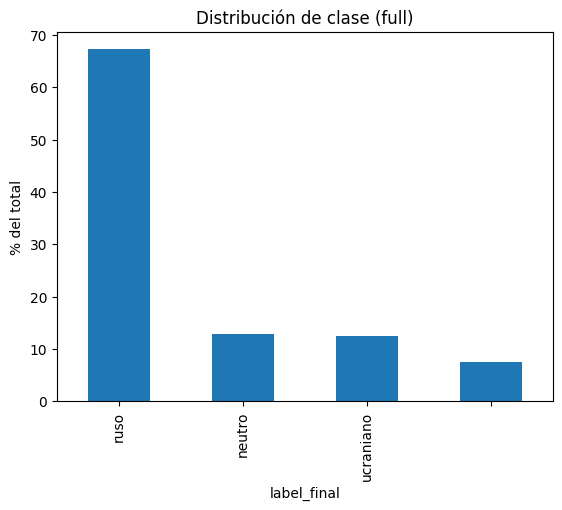

In [54]:
ax = (df["label_final"].fillna("")).value_counts(normalize=True).mul(100).plot(kind="bar")
ax.set_ylabel("% del total"); ax.set_title("Distribución de clase (full)")


In [ ]:

mask = (pmax>=0.70) & (marg>=0.10)
print("Cobertura aceptados:", mask.mean())
print(classification_report(yva[mask], y_pred[mask], target_names=LABELS, digits=3))


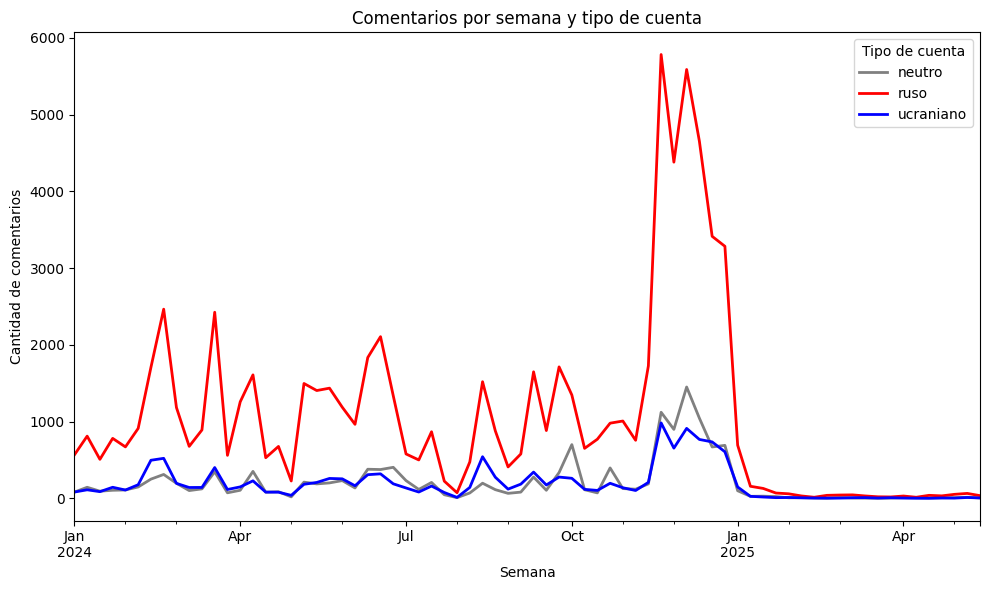

In [27]:
# Agrupar por semana y por tipo de cuenta
colors = {"ruso":"red", "ucraniano":"blue", "neutro":"gray"}

timeline = (
    df
    .groupby([pd.Grouper(key='fecha', freq='W'), 'label_final'])
    .size()
    .unstack(fill_value=0)
)

# Graficar líneas por categoría
plt.figure(figsize=(10, 6))
timeline.plot(
    ax=plt.gca(),
    color=[colors[c] for c in timeline.columns],
    linewidth=2
)
plt.title("Comentarios por semana y tipo de cuenta")
plt.ylabel("Cantidad de comentarios")
plt.xlabel("Semana")
plt.legend(title="Tipo de cuenta")
plt.tight_layout()
plt.show()
